In [24]:
from bs4 import BeautifulSoup as bs
import pandas as pd
pd.set_option('display.max_colwidth', 500)
import numpy as np
import time
import requests
import random
import aiohttp
import seaborn as sns

In [2]:
async def getJSONData(full_url):
    try:
        async with aiohttp.ClientSession() as session:
            async with session.get(full_url) as r:
                if r.status == 200:
                    js = await r.json()
                    return js
    except:
        return None


In [3]:
def getTrackData(player_id):
    url = 'https://mkwlounge.gg/ladder/player.php?player_id={}&ladder_id=3'.format(player_id)
    # print(url)
    playerpage = requests.get(url, timeout=3)
    playersoup = bs(playerpage.content)
    playertables = playersoup.find_all('table')
    dfs = pd.read_html(str(playertables))[3]
    return dfs

In [4]:
def formatTrackData(df, index):
    df.drop(['Std Dev Time', 'Average Points', 'Fastest Time', 'Slowest Time'], axis=1, inplace=True)
    melted = df.pivot(index = 'Engine', columns='Track')
    melted = melted.drop('Mirror', axis=0, errors='ignore')
    melted = melted.drop('100cc', axis=0, errors='ignore')
    melted = melted.rename(index={'150cc': index})
    return melted

In [5]:
upperDict = {'Average Placement':'AP',
             'Average Time': 'AT',
             'Races': 'R',
             'player_id':'player_id'}
def renameCols(df):
    df.rename(columns=lambda x: upperDict[x], level=0, inplace=True)
    df.columns = [' '.join(col).strip() for col in df.columns.values]
    df.drop(['AT -','AP -', 'R -'], axis=1, inplace=True)
    df.rename(columns=lambda c: c.replace(' (Nintendo)',''), inplace=True)
    df.index.name = None
    return df

In [6]:
async def getPlayerData():
    metadata = await getJSONData('https://www.mkwlounge.gg/api/ladderplayer.php?ladder_type=rt&all=1')
    playerdata = pd.DataFrame(metadata['results'])
    playerdata = playerdata[['player_id','player_name','current_mmr','current_lr','current_class','win_percentage','win10_percentage','average_score','average10_score','total_events']]
    playerdata = playerdata.loc[playerdata["total_events"]!= 0]
    playerdata = playerdata.loc[playerdata["current_mmr"] >= 0]
    return playerdata

In [25]:
playerdata = await getPlayerData()
playerdata.head()

,player_id,player_name,current_mmr,current_lr,current_class,win_percentage,win10_percentage,average_score,average10_score,total_events
0,260,Az,17155,15757,Class X,0.962963,1.000000,99.0370,96.1000,54
1,1207,Kevin,14339,15268,Class X,0.769841,0.555556,89.2217,78.7500,127
2,290,barney,14495,14979,Class X,0.784946,0.600000,91.0257,90.7000,94
3,1614,Kasperinos,13902,14817,Class X,0.758242,0.400000,90.2771,76.9286,92
4,1043,Fox,13837,14535,Class X,0.684783,0.200000,92.1954,83.9000,92


In [26]:


dfs = []
i =0
for index, row in playerdata.iterrows():
    trackdata = getTrackData(row['player_id'])
    formatData = formatTrackData(trackdata, index)
    formatData['player_id'] = row['player_id']
    dfs.append(formatData)
    # if i %100 == 0:
    #     print('working: ' + str(i))
    # i = i + 1

trackdata = pd.DataFrame().append(dfs)
trackdata = renameCols(trackdata)
trackdata.head()

,AP DS Delfino Square,AP DS Desert Hills,AP DS Peach Gardens,AP DS Yoshi Falls,AP GBA Bowser Castle 3,AP GBA Shy Guy Beach,AP GCN DK Mountain,AP GCN Mario Circuit,AP GCN Peach Beach,AP GCN Waluigi Stadium,...,R Wii Luigi Circuit,R Wii Maple Treeway,R Wii Mario Circuit,R Wii Moo Moo Meadows,R Wii Moonview Highway,R Wii Mushroom Gorge,R Wii Rainbow Road,R Wii Toad's Factory,R Wii Wario's Gold Mine,player_id
0,5th,5th,5th,4th,5th,3rd,5th,4th,5th,5th,...,46.0,59.0,24.0,17.0,97.0,128.0,16.0,39.0,14.0,260
1,6th,5th,5th,5th,5th,5th,5th,6th,6th,6th,...,146.0,121.0,61.0,24.0,217.0,304.0,36.0,79.0,54.0,1207
2,6th,5th,6th,4th,5th,9th,5th,5th,6th,5th,...,61.0,67.0,22.0,21.0,87.0,122.0,18.0,42.0,34.0,290
3,5th,5th,5th,5th,5th,5th,5th,7th,5th,5th,...,55.0,43.0,26.0,19.0,102.0,104.0,7.0,36.0,22.0,1614
4,6th,5th,5th,6th,5th,3rd,4th,6th,6th,5th,...,58.0,54.0,20.0,15.0,62.0,104.0,13.0,31.0,22.0,1043


In [27]:
combodata = pd.merge(playerdata,trackdata, left_on='player_id', right_on='player_id')
combodata.head()

,player_id,player_name,current_mmr,current_lr,current_class,win_percentage,win10_percentage,average_score,average10_score,total_events,...,R Wii Koopa Cape,R Wii Luigi Circuit,R Wii Maple Treeway,R Wii Mario Circuit,R Wii Moo Moo Meadows,R Wii Moonview Highway,R Wii Mushroom Gorge,R Wii Rainbow Road,R Wii Toad's Factory,R Wii Wario's Gold Mine
0,260,Az,17155,15757,Class X,0.962963,1.000000,99.0370,96.1000,54,...,61.0,46.0,59.0,24.0,17.0,97.0,128.0,16.0,39.0,14.0
1,1207,Kevin,14339,15268,Class X,0.769841,0.555556,89.2217,78.7500,127,...,161.0,146.0,121.0,61.0,24.0,217.0,304.0,36.0,79.0,54.0
2,290,barney,14495,14979,Class X,0.784946,0.600000,91.0257,90.7000,94,...,94.0,61.0,67.0,22.0,21.0,87.0,122.0,18.0,42.0,34.0
3,1614,Kasperinos,13902,14817,Class X,0.758242,0.400000,90.2771,76.9286,92,...,73.0,55.0,43.0,26.0,19.0,102.0,104.0,7.0,36.0,22.0
4,1043,Fox,13837,14535,Class X,0.684783,0.200000,92.1954,83.9000,92,...,70.0,58.0,54.0,20.0,15.0,62.0,104.0,13.0,31.0,22.0


In [28]:
combodata.to_csv('datasets/loungedata.csv', index=False)

## If data has already been sourced

In [7]:
combodata = pd.read_csv('datasets/loungedata.csv')
combodata.head()

,player_id,player_name,current_mmr,current_lr,current_class,win_percentage,win10_percentage,average_score,average10_score,total_events,...,R Wii Koopa Cape,R Wii Luigi Circuit,R Wii Maple Treeway,R Wii Mario Circuit,R Wii Moo Moo Meadows,R Wii Moonview Highway,R Wii Mushroom Gorge,R Wii Rainbow Road,R Wii Toad's Factory,R Wii Wario's Gold Mine
0,260,Az,17155,15757,Class X,0.962963,1.000000,99.0370,96.1000,54,...,61.0,46.0,59.0,24.0,17.0,97.0,128.0,16.0,39.0,14.0
1,1207,Kevin,14339,15268,Class X,0.769841,0.555556,89.2217,78.7500,127,...,161.0,146.0,121.0,61.0,24.0,217.0,304.0,36.0,79.0,54.0
2,290,barney,14495,14979,Class X,0.784946,0.600000,91.0257,90.7000,94,...,94.0,61.0,67.0,22.0,21.0,87.0,122.0,18.0,42.0,34.0
3,1614,Kasperinos,13902,14817,Class X,0.758242,0.400000,90.2771,76.9286,92,...,73.0,55.0,43.0,26.0,19.0,102.0,104.0,7.0,36.0,22.0
4,1043,Fox,13837,14535,Class X,0.684783,0.200000,92.1954,83.9000,92,...,70.0,58.0,54.0,20.0,15.0,62.0,104.0,13.0,31.0,22.0


In [8]:
combodata['current_class'] = combodata['current_class'].astype('category')
combodata.head()

,player_id,player_name,current_mmr,current_lr,current_class,win_percentage,win10_percentage,average_score,average10_score,total_events,...,R Wii Koopa Cape,R Wii Luigi Circuit,R Wii Maple Treeway,R Wii Mario Circuit,R Wii Moo Moo Meadows,R Wii Moonview Highway,R Wii Mushroom Gorge,R Wii Rainbow Road,R Wii Toad's Factory,R Wii Wario's Gold Mine
0,260,Az,17155,15757,Class X,0.962963,1.000000,99.0370,96.1000,54,...,61.0,46.0,59.0,24.0,17.0,97.0,128.0,16.0,39.0,14.0
1,1207,Kevin,14339,15268,Class X,0.769841,0.555556,89.2217,78.7500,127,...,161.0,146.0,121.0,61.0,24.0,217.0,304.0,36.0,79.0,54.0
2,290,barney,14495,14979,Class X,0.784946,0.600000,91.0257,90.7000,94,...,94.0,61.0,67.0,22.0,21.0,87.0,122.0,18.0,42.0,34.0
3,1614,Kasperinos,13902,14817,Class X,0.758242,0.400000,90.2771,76.9286,92,...,73.0,55.0,43.0,26.0,19.0,102.0,104.0,7.0,36.0,22.0
4,1043,Fox,13837,14535,Class X,0.684783,0.200000,92.1954,83.9000,92,...,70.0,58.0,54.0,20.0,15.0,62.0,104.0,13.0,31.0,22.0


## Data plotting and EDA

In [9]:
sns.set_style('whitegrid')
sns.set_context('talk')
sns.set(rc={'figure.figsize':(11.7,8.27)})

<AxesSubplot:xlabel='current_mmr', ylabel='Count'>

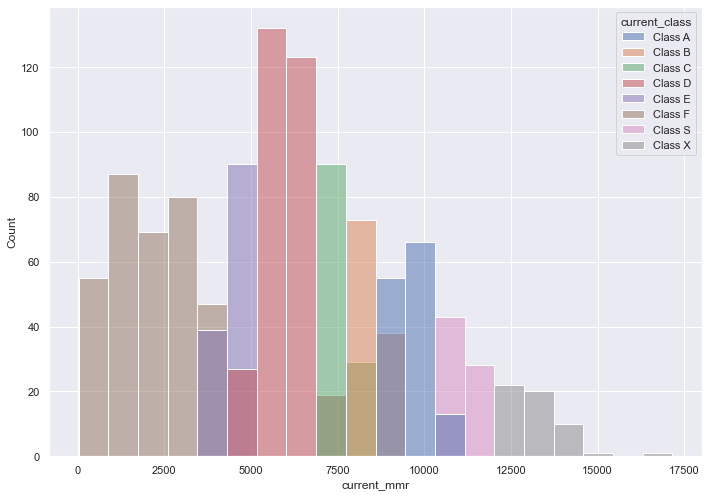

In [10]:
sns.histplot(data = combodata, x='current_mmr', hue = 'current_class', bins=20)

In [11]:
combodata.describe()

,player_id,current_mmr,current_lr,win_percentage,win10_percentage,average_score,average10_score,total_events,R DS Delfino Square,R DS Desert Hills,...,R Wii Koopa Cape,R Wii Luigi Circuit,R Wii Maple Treeway,R Wii Mario Circuit,R Wii Moo Moo Meadows,R Wii Moonview Highway,R Wii Mushroom Gorge,R Wii Rainbow Road,R Wii Toad's Factory,R Wii Wario's Gold Mine
count,1254.000000,1254.000000,1254.000000,1254.000000,1254.000000,1254.000000,1254.000000,1254.000000,1181.000000,852.000000,...,1125.000000,1090.000000,1127.000000,967.000000,1027.000000,1156.000000,1195.000000,1041.000000,1177.000000,1038.000000
mean,2250.086124,6124.543062,3441.677831,0.598957,0.576322,66.932255,66.877797,29.532695,32.121931,5.436620,...,26.919111,18.032110,22.084295,9.497415,8.755599,33.475779,42.460251,10.855908,27.320306,11.328516
std,1244.542905,3269.578923,3006.665797,0.276831,0.290761,15.867063,16.286142,38.334273,38.124311,5.430425,...,32.372219,23.287359,25.759528,10.666590,9.152043,41.859074,53.459097,12.131506,31.636894,12.079014
min,5.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1186.750000,3718.750000,1047.250000,0.500000,0.407143,61.892050,60.874975,4.000000,5.000000,2.000000,...,5.000000,3.000000,4.000000,2.000000,2.000000,5.000000,6.000000,3.000000,5.000000,3.000000
50%,2277.500000,6058.000000,2821.500000,0.661494,0.600000,71.000000,69.700000,14.000000,19.000000,4.000000,...,16.000000,10.000000,13.000000,5.000000,6.000000,18.000000,23.000000,7.000000,16.000000,7.000000
75%,3348.250000,8459.750000,4943.750000,0.750000,0.800000,76.170325,77.200000,42.000000,46.000000,7.000000,...,38.000000,23.000000,30.000000,14.000000,12.000000,48.000000,60.000000,15.000000,38.000000,16.000000
max,4166.000000,17155.000000,15757.000000,1.000000,1.000000,111.667000,111.667000,262.000000,419.000000,42.000000,...,293.000000,202.000000,233.000000,95.000000,93.000000,454.000000,457.000000,133.000000,354.000000,122.000000


In [38]:
combodata.loc[combodata['player_id'] == 4088]

,player_id,player_name,current_mmr,current_lr,current_class,win_percentage,win10_percentage,average_score,average10_score,total_events,...,R Wii Koopa Cape,R Wii Luigi Circuit,R Wii Maple Treeway,R Wii Mario Circuit,R Wii Moo Moo Meadows,R Wii Moonview Highway,R Wii Mushroom Gorge,R Wii Rainbow Road,R Wii Toad's Factory,R Wii Wario's Gold Mine
423,4088,fordj262,4226,4116,Class E,0.75,0.75,85.0,85.0,4,...,1.0,1.0,1.0,NaN,1.0,NaN,2.0,1.0,2.0,NaN


In [41]:
combodata.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1257 entries, 0 to 1256
Data columns (total 106 columns):
 #    Column                      Non-Null Count  Dtype   
---   ------                      --------------  -----   
 0    player_id                   1257 non-null   int64   
 1    player_name                 1257 non-null   object  
 2    current_mmr                 1257 non-null   int64   
 3    current_lr                  1257 non-null   int64   
 4    current_class               1257 non-null   category
 5    win_percentage              1257 non-null   float64 
 6    win10_percentage            1257 non-null   float64 
 7    average_score               1257 non-null   float64 
 8    average10_score             1257 non-null   float64 
 9    total_events                1257 non-null   int64   
 10   AP DS Delfino Square        1257 non-null   object  
 11   AP DS Desert Hills          1257 non-null   object  
 12   AP DS Peach Gardens         1257 non-null   object  
 13   A

In [18]:
combodata.shape

(1257, 106)

In [25]:
combodata['AP DS Yoshi Falls'] = combodata['AP DS Yoshi Falls'].replace(np.nan, 0)

## Filling Na valuse

In [33]:
APcols = combodata.columns[10:42]
ATcols = combodata.columns[42:74]
Rcols = combodata.columns[74:106]

In [38]:
for r in Rcols:
    combodata[r] = combodata[r].replace(np.nan, 0)

In [39]:
for p in APcols:
    combodata[p] = combodata[p].replace(np.nan, 13)

In [40]:
for T in ATcols:
    combodata[T] = combodata[T].replace(np.nan, np.inf)